```{eval-rst}
.. include:: sinebow.rst

```
{sinebow22}`Gamma`
==================

One of the more trivial uses of good binary segmentation (let alone best-in-class *instance* segmentation) is the ability to adjust an image based on foreground/background values. 

{header-2}`Example Image`
--------------------------
To start off, take our example image:

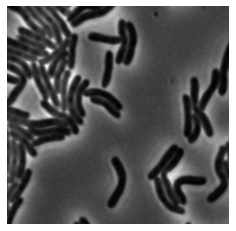

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')  # some plot elements will not be visible in light mode
dpi = 300
mpl.rcParams['figure.dpi'] = dpi
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

%matplotlib inline

import numpy as np

from cellpose_omni import io
im = io.imread('test_files/e1t1_crop.tif')

plt.imshow(im,cmap='gray')
plt.axis('off')
plt.show()

This image is 16-bit and already adjusted to span the entire bit depth:

In [ ]:
print(im.dtype, im.ptp()==(2**16-1))

uint16 True


{header-2}`Exposure and outliers`
----------------------------------

Raw data is often under- or over-exposed and can contain outliers where pixels are saturated. We can simulate this as follows:

50% image intensity (no apparent change):


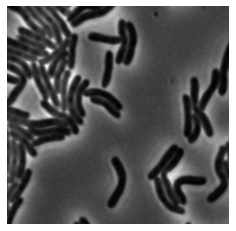

Outlier pixel makes everything else look dark:


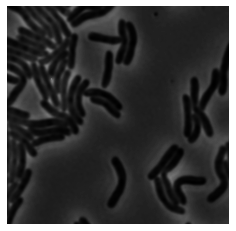

In [ ]:
im_bad = im * .5 # reduce brightness by 50%
print('50% image intensity (no apparent change):')
plt.imshow(im_bad,cmap='gray')
plt.axis('off')
plt.show()


im_bad[im.shape[0]//3,im.shape[1]//5] = im_bad.max()*2 # add a bright pixel 
print('Outlier pixel makes everything else look dark:')
plt.imshow(im_bad,cmap='gray')
plt.axis('off')
plt.show()

The `plt.imshow` command simply maps the minimum value of the image to 0 and the maximum value of the image to 1, i.e. it applies standard *0-1 min-max normalization*. This explains the dark appearance once we add in a bright pixel, as most of the image gets mapped to the bottom half of the available color map.

This is annoying when visualizing images next to each other, but it is particularly problematic when we need to standardize the images we feed into a neural network. We can choose to make all images 0-1, 0-255, etc. (and these can go above or below the minimum and maximum by a little), but it is much harder for a network to learn foreground from background if the images are chaotically rescaled like the above example (chaotic meaning that the image darkening is highly sensitive to the particular condition of whether or not there are saturated pixels). 

We solve this by normalizing the image not by the absolute min and max, but by percentiles. We set pixels at or below the 0.01 percentile to 0 and those at or above the 99.99th percentile to 1. (Cellpose uses 1 and 99, but this will mess up images with very few cells compared to background). 


normalize99() fixes the image:


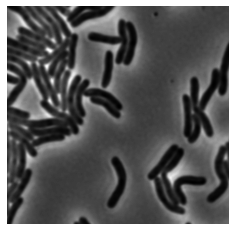

In [ ]:
from omnipose.utils import normalize99

im_fixed = normalize99(im_bad)
print('normalize99() fixes the image:')
plt.imshow(im_fixed,cmap='gray')
plt.axis('off')
plt.show()

With an image that has been properly normalized from 0 to 1, we can further adjust it. Right now we cannot see a lot of detail in the dark parts of the image; what we can do is raise the image to some power, called **gammma adjustment**. Because $0^x = 0$ and $1^x = 1$, we can make the image globally brighter or darker without affecting the total range:


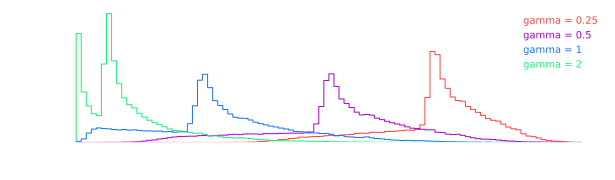

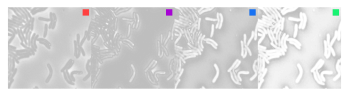

In [ ]:
%matplotlib inline
from omnipose.utils import sinebow

im_gamma = []
gamma = [0.25, 0.5, 1, 2]
N = len(gamma)

darkmode = 1
if darkmode:
    plt.style.use('dark_background')
    axcol = 'w'
    background_color = 'k'
else:
    mpl.rcParams.update(mpl.rcParamsDefault)
    axcol = 'k'
    background_color = np.array([1,1,1,1])

    
dpi = 300
mpl.rcParams['figure.dpi'] = dpi
mpl.rcParams["axes.facecolor"] = [0,0,0,0]
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

w=10
labelsize = 10
fig,ax = plt.subplots(figsize=(w,w/N),facecolor='#0000')

color = sinebow(N+1)
for j,g in enumerate(gamma):
    i = im_fixed**g
    im_gamma.append(i)
    plt.hist(i.flatten(),
             bins=100,
             label='gamma = {}'.format(g),
             color=color[j+1],
             histtype='step',
             density=True)

l = plt.legend(prop={'size': labelsize},frameon=False)
for text,c in zip(l.get_texts(),[color[i] for i in range(1,N+1)]):
    text.set_color(c)
for item in l.legendHandles:
    item.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.patch.set_alpha(0.0)
plt.xlabel('Intensity',size=labelsize)
plt.ylabel('PDF',size=labelsize)

plt.show()

imstack = np.hstack(im_gamma)
sz = np.array(imstack.shape)
fig =  plt.figure(facecolor='#0000') #sz/sz[0]*width figsize=sz/sz[0]*1000*px,

imstack = np.stack([imstack]*4,axis=-1)
s = im.shape
pad = 10
width = 30
for j in range(1,N+1):
    slc = (slice(pad,pad+width),slice(s[1]*j-(pad+width),s[1]*j-pad),Ellipsis)
    imstack[slc] = color[j]

# matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.imshow(imstack)
plt.axis('off')

plt.show()

Note that fractional powers only work (without going into complex numbers) if the image values are nonnegative. 


{header-2}`Semantic gamma normalization`
-----------------------------------------
We can next use image segmentation in combination with gamma adjustment to normalize image brightness. This is very handy for making figures with images coming from different microscopes or optical configurations. To demonstrate, let's load in the image set from our *mono_channel_bact* notebook and the corresponding masks we made with Omnipose.

In [ ]:
from pathlib import Path
import os
from cellpose_omni import io, transforms

basedir = os.path.join(Path.cwd().parent,'docs','test_files')
mask_filter='_cp_masks'
img_names = io.get_image_files(basedir,mask_filter,look_one_level_down=True)
mask_names = io.get_label_files(img_names,subfolder='masks')
imgs =  [io.imread(i) for i in img_names]
masks = [io.imread(m) for m in mask_names]

Now we will compare standard normalization to what I am calling "semantic gamma normalization". My implementation of it can be found in `omnipose.utils`, which simply answers the question: "what is the power to which I need to raise my image such that the average background becomes equal to a given value?". From left to right, I plot `im/max(im.dtype)` (so min>=0 and max=1), 0-1 remapping of `im` (`recsale`), percentile remapping of `im` (`normalize99`), gamma normalization to background of 1/3, and gamma normalization of background to 1/2. The output has been set to use the same colormap and interpolation (`vmin` and `vmax` are otherwise set by the min and max of the image).

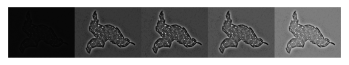

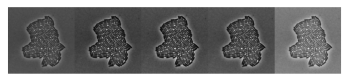

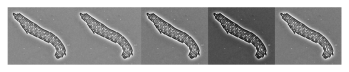

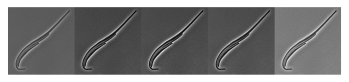

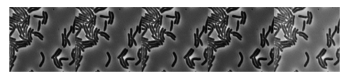

In [ ]:
from omnipose.utils import rescale, normalize_image

for im, mask in zip(imgs,masks):
    
    # format the image
    im = transforms.move_min_dim(im) # move the channel dimension last
    if len(im.shape)>2:
        im = im[:,:,1] 
    
    
    im_rescale = rescale(im)
    im_norm = normalize99(im)
    im_gamma_3 = normalize_image(im, mask>0, bg=1/3)
    im_gamma_2 = normalize_image(im, mask>0, bg=1/2)
    
    stack = np.hstack([im/np.iinfo(im.dtype).max,im_rescale,im_norm,im_gamma_3, im_gamma_2])
    
    sz = np.array(stack.shape)
    plt.figure(facecolor='#0000') #figsize=(5,)*2, figsize=sz/sz[0]*1000*px,
    plt.imshow(stack,vmin=0,vmax=1, cmap='gray')
    plt.axis('off')

The first column provides an essentially 'raw' view of the image, as it has not been shifted or stretched relative to the original max and min of its data type. As noted in the segmentation notebook, that first image is super dark because it is an 8-bit image, 0-255, but only takes on values from 4 to 22. My code above divides by 255 for uint8 images and 65535 for the last uint16 image. 

The second and third columns do stretch the image to fill the whole 0-1 range, but you can see how the images still have different background intensity. My function in columns 4 and 5 normalize the background to a constant value. Well-exposed bacterial phase contrast images seem to have a 'natural' background value of about 1/3. 